In [ ]:
#Author: Nan Cao, Keyu Wei, Yunjie Long

In [ ]:
# Install all the dependencies in Colab environment i.e. Apache Spark 2.4.4 with hadoop 2.7, Java 8 and Findspark to locate the spark in the system
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
!ls

sample_data  spark-3.0.1-bin-hadoop2.7	spark-3.0.1-bin-hadoop2.7.tgz


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import pandas as pd
import numpy as np
data = pd.read_csv('rebased.csv',index_col=0)
data.head()

#data = spark.read.csv('rebased.csv',inferSchema=True, header =True)


,nikkei,aord,nyse,dax,ftse,hangseng,sp500,djia
2013-09-06,13773.81553,5147.569693,9381.841760,8281.339919,6513.256981,22622.10854,1645.839233,14804.90982
2013-09-09,14116.07385,5182.994259,9381.841760,8281.339919,6496.753317,22751.54362,1645.839233,14804.90982
2013-09-10,14332.83480,5202.507791,9500.936954,8322.912648,6549.726198,22977.55250,1662.376383,14929.43477
2013-09-11,14334.53407,5234.229789,9581.384769,8494.090924,6554.143092,22938.04095,1674.587820,15056.23930
2013-09-12,14296.97131,5241.835063,9615.910464,8543.557846,6554.690230,22954.62160,1679.699122,15190.57638


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
ReturnPanel=pd.DataFrame()
ReturnPanel['sp500']=np.log(data['sp500'])-np.log(data['sp500'].shift(1))
ReturnPanel['nikkei']=np.log(data['nikkei'])-np.log(data['nikkei'].shift(1))
ReturnPanel['aord']=np.log(data['aord'])-np.log(data['aord'].shift(1))
ReturnPanel['nyse']=np.log(data['nyse'])-np.log(data['nyse'].shift(1))
ReturnPanel['dax']=np.log(data['dax'])-np.log(data['dax'].shift(1))
ReturnPanel['ftse']=np.log(data['ftse'])-np.log(data['ftse'].shift(1))
ReturnPanel['hangseng']=np.log(data['hangseng'])-np.log(data['hangseng'].shift(1))
ReturnPanel['djia']=np.log(data['djia'])-np.log(data['djia'].shift(1))
ReturnPanel=ReturnPanel.dropna(axis=0) #drop missing values
ReturnPanel.head()

,sp500,nikkei,aord,nyse,dax,ftse,hangseng,djia
2013-09-09,0.000000,0.024545,0.006858,0.000000,0.000000,-0.002537,0.005705,0.000000
2013-09-10,0.009998,0.015239,0.003758,0.012614,0.005007,0.008121,0.009885,0.008376
2013-09-11,0.007319,0.000119,0.006079,0.008432,0.020358,0.000674,-0.001721,0.008458
2013-09-12,0.003048,-0.002624,0.001452,0.003597,0.005807,0.000083,0.000723,0.008883
2013-09-13,-0.003386,0.001209,-0.004496,-0.004990,-0.000204,-0.000786,-0.001676,-0.001695


In [ ]:
dataMatrix=pd.DataFrame()
dataMatrix['sp500']=ReturnPanel['sp500']
dataMatrix['sp500_lag']=ReturnPanel['sp500'].shift(1)
dataMatrix['nikkei']=ReturnPanel['nikkei']
dataMatrix['nikkei_lag']=ReturnPanel['nikkei'].shift(1)
dataMatrix['aord']=ReturnPanel['aord']
dataMatrix['aord_lag']=ReturnPanel['aord'].shift(1)
dataMatrix['hangseng']=ReturnPanel['hangseng']
dataMatrix['hangseng_lag']=ReturnPanel['hangseng'].shift(1)
dataMatrix['nyse_lag']=ReturnPanel['nyse'].shift(1)
dataMatrix['dax_lag']=ReturnPanel['dax'].shift(1)
dataMatrix['ftse_lag']=ReturnPanel['ftse'].shift(1)
dataMatrix['djia_lag']=ReturnPanel['djia'].shift(1)
dataMatrix=dataMatrix.dropna(axis=0)
dataMatrix.index=pd.to_datetime(dataMatrix.index)
dataMatrix.head(-5)


,sp500,sp500_lag,nikkei,nikkei_lag,aord,aord_lag,hangseng,hangseng_lag,nyse_lag,dax_lag,ftse_lag,djia_lag
2013-09-10,0.009998,0.000000,0.015239,0.024545,0.003758,0.006858,0.009885,0.005705,0.000000,0.000000,-0.002537,0.000000
2013-09-11,0.007319,0.009998,0.000119,0.015239,0.006079,0.003758,-0.001721,0.009885,0.012614,0.005007,0.008121,0.008376
2013-09-12,0.003048,0.007319,-0.002624,0.000119,0.001452,0.006079,0.000723,-0.001721,0.008432,0.020358,0.000674,0.008458
2013-09-13,-0.003386,0.003048,0.001209,-0.002624,-0.004496,0.001452,-0.001676,0.000723,0.003597,0.005807,0.000083,0.008883
2013-09-17,0.008388,-0.003386,-0.006477,0.001209,0.005832,-0.004496,0.011508,-0.001676,-0.004990,-0.000204,-0.000786,-0.001695
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-24,0.002983,-0.025183,-0.011141,-0.000591,-0.009007,0.008826,-0.018339,-0.029584,-0.037667,-0.036751,-0.018108,-0.032869
2020-09-25,0.015850,0.002983,0.005046,-0.011141,0.013774,-0.009007,-0.003251,-0.018339,0.000516,-0.002883,-0.013052,0.001953
2020-09-28,0.015982,0.015850,0.013143,0.005046,-0.000912,0.013774,0.010303,-0.003251,0.009645,-0.010957,0.003412,0.013281
2020-09-29,-0.004824,0.015982,0.001168,0.013143,0.001075,-0.000912,-0.008578,0.010303,0.015274,0.031705,0.014477,0.014979


In [ ]:
#transform to spark data frame
dataset = spark.createDataFrame(dataMatrix)
train_data=spark.createDataFrame(dataMatrix.iloc[:1340,:]) #80%
test_data=spark.createDataFrame(dataMatrix.iloc[1340:,:] )

In [ ]:
dataset.dtypes

[('sp500', 'double'),
 ('sp500_lag', 'double'),
 ('nikkei', 'double'),
 ('nikkei_lag', 'double'),
 ('aord', 'double'),
 ('aord_lag', 'double'),
 ('hangseng', 'double'),
 ('hangseng_lag', 'double'),
 ('nyse_lag', 'double'),
 ('dax_lag', 'double'),
 ('ftse_lag', 'double'),
 ('djia_lag', 'double')]

In [ ]:
numerical_features=['sp500','sp500_lag','nikkei','nikkei_lag','aord','aord_lag','hangseng','hangseng_lag','nyse_lag','dax_lag','ftse_lag','djia_lag']

In [ ]:
dataset.show(2)

+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+
|               sp500|          sp500_lag|              nikkei|          nikkei_lag|                aord|            aord_lag|            hangseng|        hangseng_lag|           nyse_lag|            dax_lag|            ftse_lag|            djia_lag|
+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+
| 0.00999770853279447|                0.0|  0.0152389075738526|0.024544773042324053|0.003757845286486372|0.006858232525361885|0.009884766567658687|0.005705312441785182|                0.0|                0.0|-0.00253707298833028|                 0

In [ ]:
assembler = VectorAssembler(inputCols=numerical_features, outputCol = 'Attributes')

output = assembler.transform(dataset)

#Input vs Output
all_data = output.select("Attributes")



In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

r1 = Correlation.corr(all_data, "Attributes").head()
print(numerical_features)
print("Pearson correlation matrix:\n" + str(r1[0]))

['sp500', 'sp500_lag', 'nikkei', 'nikkei_lag', 'aord', 'aord_lag', 'hangseng', 'hangseng_lag', 'nyse_lag', 'dax_lag', 'ftse_lag', 'djia_lag']
Pearson correlation matrix:
DenseMatrix([[ 1.00000000e+00, -2.23302607e-01,  3.00722569e-01,
               1.38050520e-01,  4.68438548e-01, -6.88612739e-02,
               1.70008806e-01,  6.34856043e-02, -2.04462486e-01,
              -7.32705482e-02, -2.99276883e-02, -2.15248567e-01],
             [-2.23302607e-01,  1.00000000e+00,  1.69459648e-01,
               3.00610980e-01,  3.45021060e-02,  4.67812990e-01,
               6.00988771e-02,  1.70006909e-01,  9.74080338e-01,
               5.99572831e-01,  5.37406421e-01,  9.76608484e-01],
             [ 3.00722569e-01,  1.69459648e-01,  1.00000000e+00,
              -1.49733734e-02,  4.83339152e-01,  3.08641404e-02,
               3.18129386e-01,  2.55600278e-02,  1.62296469e-01,
               1.52507951e-01,  2.06067216e-01,  1.76374612e-01],
             [ 1.38050520e-01,  3.00610980e-01,

From correlation matrix,we can find that response 'sp500' highly correlates with sp500_lag,nikkei,nikkei_lag,aord,nyse_lag,djia_lag.

High correlations also exist among these strong predictors. Next we first use these strong predictors to build a multiple linear regression. 

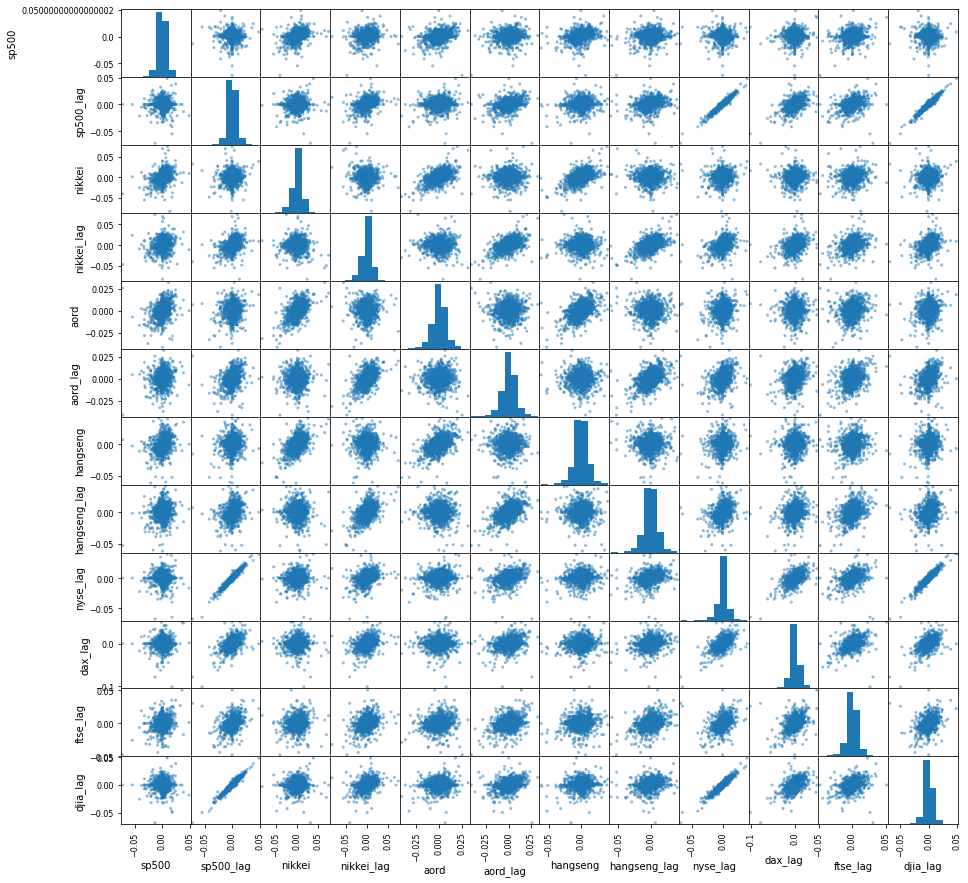

In [ ]:
from pandas.plotting import scatter_matrix
sm=scatter_matrix(dataMatrix.iloc[:1340,:],figsize=(15,15))

sp500 has weak or strong associations with preditors. Some predictors have linear pattern.  Such a situation in which two or more predictors in a multiple regression model are highly linearly related, is called **Multicollinearity **.

A principal danger of such data redundancy is that of overfitting in regression analysis models. The best regression models are those in which eacvh predictos  correlate highly with response but correlate at most only minimally with each other. Such a model is often called "low noise" and will be statistically robust (that is, it will predict reliably across numerous samples of variable sets drawn from the same population).

A popular remedy for multicolinearity  is ** principal component analysis ** (PCA)

In [ ]:
import statsmodels.formula.api as smf

VIF=pd.DataFrame()
VIF['sp500_lag']=[smf.ols(formula=' sp500_lag~nikkei+nikkei_lag+aord+nyse_lag+hangseng+djia_lag ', data=dataMatrix).fit().rsquared_adj]
VIF['nikkei']=[smf.ols(formula=' nikkei~sp500_lag+nikkei_lag+aord+nyse_lag+hangseng+djia_lag ', data=dataMatrix).fit().rsquared_adj]
VIF['nikkei_lag']=[smf.ols(formula=' nikkei_lag~nikkei+sp500_lag+aord+nyse_lag+hangseng+djia_lag ', data=dataMatrix).fit().rsquared_adj]
VIF['aord']=[smf.ols(formula=' aord~nikkei+nikkei_lag+sp500_lag+nyse_lag+hangseng+djia_lag ', data=dataMatrix).fit().rsquared_adj]
VIF['nyse_lag']=[smf.ols(formula=' nyse_lag~nikkei+nikkei_lag+aord+sp500_lag+hangseng+djia_lag ', data=dataMatrix).fit().rsquared_adj]
VIF['hangseng']=[smf.ols(formula=' hangseng~nikkei+nikkei_lag+aord+nyse_lag+sp500_lag+djia_lag ', data=dataMatrix).fit().rsquared_adj]
VIF['djia_lag']=[smf.ols(formula=' djia_lag~nikkei+nikkei_lag+aord+nyse_lag+sp500_lag+hangseng ', data=dataMatrix).fit().rsquared_adj]
VIF=VIF.transpose()
VIF.columns=['rsquared']
VIF['VIF']=1/(1-VIF['rsquared'])
VIF

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,rsquared,VIF
sp500_lag,0.966550,29.895060
nikkei,0.307763,1.444591
nikkei_lag,0.129466,1.148720
aord,0.260161,1.351645
nyse_lag,0.956480,22.978174
hangseng,0.116369,1.131694
djia_lag,0.959894,24.933762


In [ ]:
VIF=pd.DataFrame()
VIF['sp500_lag']=[smf.ols(formula=' sp500_lag~nikkei_lag+aord+hangseng+nikkei ', data=dataMatrix).fit().rsquared_adj]
VIF['nikkei']=[smf.ols(formula=' nikkei~nikkei_lag+aord+hangseng+sp500_lag ', data=dataMatrix).fit().rsquared_adj]
VIF['nikkei_lag']=[smf.ols(formula=' nikkei_lag~nikkei+aord+hangseng+sp500_lag ', data=dataMatrix).fit().rsquared_adj]
VIF['aord']=[smf.ols(formula=' aord~nikkei_lag+nikkei+hangseng+sp500_lag ', data=dataMatrix).fit().rsquared_adj]
VIF['hangseng']=[smf.ols(formula=' hangseng~aord+nikkei_lag+nikkei+sp500_lag  ', data=dataMatrix).fit().rsquared_adj]
VIF=VIF.transpose()
VIF.columns=['rsquared']
VIF['VIF']=1/(1-VIF['rsquared'])
VIF

,rsquared,VIF
sp500_lag,0.126488,1.144804
nikkei,0.305055,1.438964
nikkei_lag,0.111471,1.125455
aord,0.259281,1.350039
hangseng,0.115297,1.130323


A rule of thumb is that if any VIF >10, multicollinarity is high.
Hence with these two methods, we can tell that multicollinearity is not serious in our model.

In [ ]:
selected_features=['sp500_lag','nikkei','nikkei_lag','aord','hangseng']

In [ ]:
#Input all the features in one vector column
assembler = VectorAssembler(inputCols=selected_features, 
                            outputCol = 'features')

output = assembler.transform(train_data)
train_data = output.select("features","sp500")

output = assembler.transform(test_data)
test_data = output.select("features","sp500")


train_data.show()

+--------------------+--------------------+
|            features|               sp500|
+--------------------+--------------------+
|[0.0,0.0152389075...| 0.00999770853279447|
|[0.00999770853279...|0.007318922689930396|
|[0.00731892268993...|0.003047625945268...|
|[0.00304762594526...|-0.00338616474473...|
|[-0.0033861647447...|0.008388050341141984|
|[0.00838805034114...|0.004208849634367...|
|[0.00420884963436...|0.012104115845628982|
|[0.01210411584562...|-0.00184462287655...|
|[-0.0018446228765...|-0.01197381274795...|
|[-0.0119738127479...|-0.00260056751631...|
|[-0.0026005675163...|-0.00274321093940...|
|[-0.0027432109394...|0.003479351707729...|
|[0.00347935170772...|                 0.0|
|[0.0,0.0019985826...|-0.01012960461477...|
|[-0.0101296046147...| 0.00796675374953626|
|[0.00796675374953...|-6.66889047467478...|
|[-6.6688904746747...|-0.00901999611142...|
|[-0.0090199961114...|                 0.0|
|[0.0,0.0029760799...|-0.00151425726973...|
|[-0.0015142572697...|-0.0124087

In [ ]:
#Split training and testing data
#train_data,test_data = finalized_data.randomSplit([0.8,0.2],seed=13)

regressor = LinearRegression(featuresCol = 'features', labelCol = 'sp500')

#Learn to fit the model from training set
regressor = regressor.fit(train_data)

#To predict the prices on testing set
pred = regressor.evaluate(test_data)

#Predict the model
pred.predictions.show()

+--------------------+--------------------+--------------------+
|            features|               sp500|          prediction|
+--------------------+--------------------+--------------------+
|[0.00157784678131...|-0.00219416872553...|-9.42617810071861...|
|[-0.0021941687255...|-3.69041697554806...|5.913166104165854E-4|
|[-3.6904169755480...|0.004674350344364697|8.927920860536471E-4|
|[0.00467435034436...|-0.01917315109919...|-0.00602147094752...|
|[-0.0191731510991...|-0.00160671540560...|-0.00296752949145...|
|[-0.0016067154056...|-0.00302599860192...|-0.00354404109484...|
|[-0.0030259986019...|0.003713393847204...|-4.70268871764573...|
|[0.00371339384720...|-0.02442646908587...|-0.00204442994435...|
|[-0.0244264690858...| 0.00798398755130858|-4.87845166423170...|
|[0.00798398755130...|0.005821994388234053|8.422672724578223E-4|
|[0.00582199438823...|0.008855956969633816|7.003800071395726E-4|
|[0.00885595696963...|-0.00585443715292...| 2.48160757504714E-4|
|[-0.0058544371529...|-0.

In [ ]:
#To predict the prices on training set
pred_train = regressor.evaluate(train_data)

#Predict the model
pred_train.predictions.show()

+--------------------+--------------------+--------------------+
|            features|               sp500|          prediction|
+--------------------+--------------------+--------------------+
|[0.0,0.0152389075...| 0.00999770853279447|0.007409120009659413|
|[0.00999770853279...|0.007318922689930396|0.002073110256937...|
|[0.00731892268993...|0.003047625945268...|-7.94837551154814...|
|[0.00304762594526...|-0.00338616474473...|-0.00116485429206...|
|[-0.0033861647447...|0.008388050341141984|0.001636450555885...|
|[0.00838805034114...|0.004208849634367...|-2.56142323804914...|
|[0.00420884963436...|0.012104115845628982|0.007363779793875814|
|[0.01210411584562...|-0.00184462287655...|2.353187157475588...|
|[-0.0018446228765...|-0.01197381274795...|-0.00189674958494...|
|[-0.0119738127479...|-0.00260056751631...|0.002205706720254...|
|[-0.0026005675163...|-0.00274321093940...|0.002019262996449...|
|[-0.0027432109394...|0.003479351707729...|0.002674199215669...|
|[0.00347935170772...|   

In [ ]:
#coefficient of the regression model
coeff = regressor.coefficients

#X and Y intercept
intr = regressor.intercept

print ("The coefficient of the model is : %a" %coeff)
print ("The Intercept of the model is : %f" %intr)
summary = regressor.summary
print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
print("P Values: " + str(summary.pValues))

The coefficient of the model is : DenseVector([-0.142, 0.1599, 0.139, 0.1814, 0.0539])
The Intercept of the model is : 0.000345
Coefficient Standard Errors: [0.02656651239302709, 0.020356717504725338, 0.017399604572575725, 0.0331934896742701, 0.023184309681677936, 0.00020811280981561774]
P Values: [1.0603398847841561e-07, 8.215650382226158e-15, 2.886579864025407e-15, 5.548627801665873e-08, 0.020239116303901517, 0.09729600053992415]


In [ ]:
# Another way to summarize
def modelsummary(model):
    import numpy as np
    print ("Note: the last row is the information for Intercept")
    print ("##","-------------------------------------------------")
    print ("##","  Estimate   | Std.Error |   t Values  |   P-value")
    coef = np.append(list(model.coefficients),model.intercept)
    Summary=model.summary

    for i in range(len(Summary.pValues)):
        print ("##",'{:10.6f}'.format(coef[i]),\
        '{:12.6f}'.format(Summary.coefficientStandardErrors[i]),\
        '{:12.3f}'.format(Summary.tValues[i]),\
        '{:13.6f}'.format(Summary.pValues[i]))

    print ("##",'---')
    print ("##","Mean squared error: % .6f" \
           % Summary.meanSquaredError, ", RMSE: % .6f" \
           % Summary.rootMeanSquaredError )
    print ("##","Multiple R-squared: %f" 
           % Summary.r2, ", Total iterations: %i"
           % Summary.totalIterations)
    print("##", "MAE: % .6f" \
           % Summary.meanAbsoluteError)
   

In [ ]:
modelsummary(regressor)

Note: the last row is the information for Intercept
## -------------------------------------------------
##   Estimate   | Std.Error |   t Values  |   P-value
##  -0.142008     0.026567       -5.345      0.000000
##   0.159906     0.020357        7.855      0.000000
##   0.139040     0.017400        7.991      0.000000
##   0.181369     0.033193        5.464      0.000000
##   0.053896     0.023184        2.325      0.020239
##   0.000345     0.000208        1.659      0.097296
## ---
## Mean squared error:  0.000058 , RMSE:  0.007590
## Multiple R-squared: 0.187677 , Total iterations: 1
## MAE:  0.005012


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol="sp500", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = eval.evaluate(pred.predictions)
print("RMSE: %.5f" % rmse)

# Mean Square Error
mse = eval.evaluate(pred.predictions, {eval.metricName: "mse"})
print("MSE: %.5f" % mse)

# Mean Absolute Error
mae = eval.evaluate(pred.predictions, {eval.metricName: "mae"})
print("MAE: %.5f" % mae)

# r2 - coefficient of determination
r2 = eval.evaluate(pred.predictions, {eval.metricName: "r2"})
print("r2: %.5f" %r2)


RMSE: 0.01615
MSE: 0.00026
MAE: 0.00996
r2: 0.31170


In [ ]:
# Train data
# Root Mean Square Error
rmse_train = eval.evaluate(pred_train.predictions)
print("Train RMSE: %.5f" % rmse_train)

# Mean Square Error
mse_train = eval.evaluate(pred_train.predictions, {eval.metricName: "mse"})
print("Train MSE: %.5f" % mse_train)

# Mean Absolute Error
mae_train = eval.evaluate(pred_train.predictions, {eval.metricName: "mae"})
print("Train MAE: %.5f" % mae_train)

# r2 - coefficient of determination
r2_train = eval.evaluate(pred_train.predictions, {eval.metricName: "r2"})
print("Train r2: %.5f" %r2_train)


Train RMSE: 0.00759
Train MSE: 0.00006
Train MAE: 0.00501
Train r2: 0.18768


In [ ]:
pred.predictions.show()

+--------------------+--------------------+--------------------+
|            features|               sp500|          prediction|
+--------------------+--------------------+--------------------+
|[0.00157784678131...|-0.00219416872553...|-9.42617810071861...|
|[-0.0021941687255...|-3.69041697554806...|5.913166104165854E-4|
|[-3.6904169755480...|0.004674350344364697|8.927920860536471E-4|
|[0.00467435034436...|-0.01917315109919...|-0.00602147094752...|
|[-0.0191731510991...|-0.00160671540560...|-0.00296752949145...|
|[-0.0016067154056...|-0.00302599860192...|-0.00354404109484...|
|[-0.0030259986019...|0.003713393847204...|-4.70268871764573...|
|[0.00371339384720...|-0.02442646908587...|-0.00204442994435...|
|[-0.0244264690858...| 0.00798398755130858|-4.87845166423170...|
|[0.00798398755130...|0.005821994388234053|8.422672724578223E-4|
|[0.00582199438823...|0.008855956969633816|7.003800071395726E-4|
|[0.00885595696963...|-0.00585443715292...| 2.48160757504714E-4|
|[-0.0058544371529...|-0.

In [ ]:
pred_train.predictions.show()

+--------------------+--------------------+--------------------+
|            features|               sp500|          prediction|
+--------------------+--------------------+--------------------+
|[0.0,0.0152389075...| 0.00999770853279447|0.007409120009659413|
|[0.00999770853279...|0.007318922689930396|0.002073110256937...|
|[0.00731892268993...|0.003047625945268...|-7.94837551154814...|
|[0.00304762594526...|-0.00338616474473...|-0.00116485429206...|
|[-0.0033861647447...|0.008388050341141984|0.001636450555885...|
|[0.00838805034114...|0.004208849634367...|-2.56142323804914...|
|[0.00420884963436...|0.012104115845628982|0.007363779793875814|
|[0.01210411584562...|-0.00184462287655...|2.353187157475588...|
|[-0.0018446228765...|-0.01197381274795...|-0.00189674958494...|
|[-0.0119738127479...|-0.00260056751631...|0.002205706720254...|
|[-0.0026005675163...|-0.00274321093940...|0.002019262996449...|
|[-0.0027432109394...|0.003479351707729...|0.002674199215669...|
|[0.00347935170772...|   

Text(0.5, 1.0, 'Test Data Visualization')

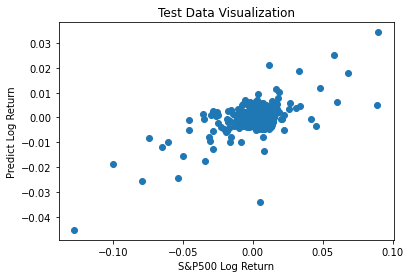

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
predict = pred.predictions.select("prediction").toPandas()
sp500 = pred.predictions.select("sp500").toPandas()

plt.scatter(sp500,predict)
plt.xlabel("S&P500 Log Return")
plt.ylabel("Predict Log Return")
plt.title("Test Data Visualization")

Text(0.5, 1.0, 'Train Data Visualization')

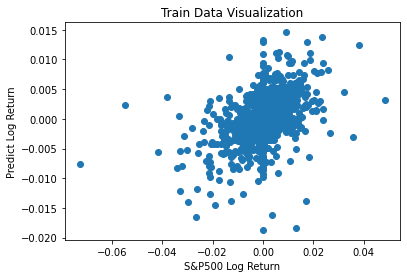

In [ ]:
predict_train = pred_train.predictions.select("prediction").toPandas()
sp500_train = pred_train.predictions.select("sp500").toPandas()

plt.scatter(sp500_train,predict_train)
plt.xlabel("S&P500 Log Return")
plt.ylabel("Predict Log Return")
plt.title("Train Data Visualization")

#### Decision Tree regression

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

In [ ]:
dtr = DecisionTreeRegressor(featuresCol="features",labelCol="sp500",maxDepth = 5,maxBins=32)

#To train the data on training set
model2 = dtr.fit(train_data)

#To make prediction on test data
dtr_prediction = model2.transform(test_data)

dtr_prediction.show(5)

+--------------------+--------------------+--------------------+
|            features|               sp500|          prediction|
+--------------------+--------------------+--------------------+
|[0.00157784678131...|-0.00219416872553...|-0.00158466159049...|
|[-0.0021941687255...|-3.69041697554806...|9.505753272662078E-4|
|[-3.6904169755480...|0.004674350344364697|9.505753272662078E-4|
|[0.00467435034436...|-0.01917315109919...|-0.00201617105095...|
|[-0.0191731510991...|-0.00160671540560...|-0.00201617105095...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Select (prediction, true label) and compute test error
dtr_evaluator = RegressionEvaluator(
    labelCol="sp500", predictionCol="prediction", metricName="rmse")

rmse = dtr_evaluator.evaluate(dtr_prediction)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Mean Square Error
mse = dtr_evaluator.evaluate(dtr_prediction, {dtr_evaluator.metricName: "mse"})
print("MSE: %.5f" % mse)

# Mean Absolute Error
mae = dtr_evaluator.evaluate(dtr_prediction, {dtr_evaluator.metricName: "mae"})
print("MAE: %.5f" % mae)



Root Mean Squared Error (RMSE) on test data = 0.0210426
MSE: 0.00044
MAE: 0.01183


Text(0.5, 1.0, 'Decision Tree Test Data Visualization')

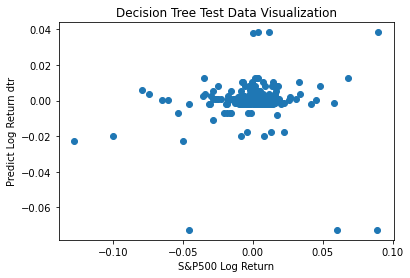

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

dtr_predict = dtr_prediction.select("prediction").toPandas()
sp500 = dtr_prediction.select("sp500").toPandas()

plt.scatter(sp500,dtr_predict)
plt.xlabel("S&P500 Log Return")
plt.ylabel("Predict Log Return dtr")
plt.title("Decision Tree Test Data Visualization")

#### Gradiant boosted Tree regression

In [ ]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol = 'features', labelCol = 'sp500', maxIter=10)

# Train the gbt_model on train_data
gbt_model = gbt.fit(train_data)

#base on gbt_model, make prediction on test data
gbt_predictions = gbt_model.transform(test_data)

gbt_predictions.select('prediction', 'sp500', 'features').show(5)

+--------------------+--------------------+--------------------+
|          prediction|               sp500|            features|
+--------------------+--------------------+--------------------+
|-0.00371524057502...|-0.00219416872553...|[0.00157784678131...|
|0.001438972101460...|-3.69041697554806...|[-0.0021941687255...|
|0.001650857048081...|0.004674350344364697|[-3.6904169755480...|
|-0.00441696184378...|-0.01917315109919...|[0.00467435034436...|
|4.356814367636572E-4|-0.00160671540560...|[-0.0191731510991...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Select (prediction, true label) and compute test error
gbt_evaluator = RegressionEvaluator(
    labelCol="sp500", predictionCol="prediction", metricName="rmse")

rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Mean Square Error
mse = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: "mse"})
print("MSE: %.5f" % mse)

# Mean Absolute Error
mae = gbt_evaluator.evaluate(gbt_predictions, {gbt_evaluator.metricName: "mae"})
print("MAE: %.5f" % mae)


Root Mean Squared Error (RMSE) on test data = 0.0212718
MSE: 0.00045
MAE: 0.01178


Text(0.5, 1.0, 'Gradient Boosted Tree Reg Test Data Visualization')

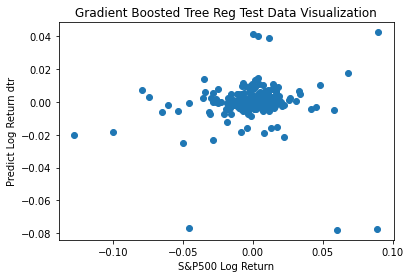

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

gbt_predict = gbt_predictions.select("prediction").toPandas()
sp500 = gbt_predictions.select("sp500").toPandas()

plt.scatter(sp500,gbt_predict)
plt.xlabel("S&P500 Log Return")
plt.ylabel("Predict Log Return dtr")
plt.title("Gradient Boosted Tree Reg Test Data Visualization")

To better tune the model, we can cross validate. It knows how to call the GBT algorithm with different hyperparameter settings. It will train multiple models and choose the best one, based on minimizing some metric. 

In [ ]:
# corss-validating hyperparameters for tree-depth and max iteration
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Define a grid of hyperparameters to test:
#  - maxDepth: max depth of each decision tree in the GBT ensemble
#  - maxIter: iterations, i.e., number of trees in each GBT ensemble
paramGrid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [2, 5])\
  .addGrid(gbt.maxIter, [10, 100])\
  .build()

In [ ]:
# Declare the CrossValidator, which runs model tuning for us.
cv = CrossValidator(estimator=gbt, evaluator=gbt_evaluator, estimatorParamMaps=paramGrid)

cvModel = cv.fit(train_data)

cv_prediction = cvModel.transform(test_data)


In [ ]:
selected = cv_prediction.select('prediction', 'sp500', 'features').show(5)

+--------------------+--------------------+--------------------+
|          prediction|               sp500|            features|
+--------------------+--------------------+--------------------+
|-0.00105823927133...|-0.00219416872553...|[0.00157784678131...|
|3.063886729929174...|-3.69041697554806...|[-0.0021941687255...|
| 9.82794307479804E-4|0.004674350344364697|[-3.6904169755480...|
|-0.00164051821436...|-0.01917315109919...|[0.00467435034436...|
|-0.00383747518867...|-0.00160671540560...|[-0.0191731510991...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
# Select (prediction, true label) and compute test error
# We define rmse as the evaluation metric. Thus rmse tells CrossValidator how well we are doing by comparing the true labels with predictions.
cv_evaluator = RegressionEvaluator(
    labelCol="sp500", predictionCol="prediction", metricName="rmse")

rmse = cv_evaluator.evaluate(cv_prediction)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Mean Square Error
mse = cv_evaluator.evaluate(cv_prediction, {cv_evaluator.metricName: "mse"})
print("MSE: %.5f" % mse)

# Mean Absolute Error
mae = cv_evaluator.evaluate(cv_prediction, {cv_evaluator.metricName: "mae"})
print("MAE: %.5f" % mae)


Root Mean Squared Error (RMSE) on test data = 0.0186487
MSE: 0.00035
MAE: 0.01082


Comparison of result:
After corss-validation, the RMSE, MSE, MAE all shows that the prediction is more accurate compared to those without cross-validation. 

### Trading Strategy

In [ ]:
data_merge = pd.merge(data, dataMatrix, left_index=True, right_index=True)

In [ ]:
Trade_Test=pd.DataFrame()
Test_data = data_merge.iloc[1340:,:]
Trade_Test['Price']=Test_data['sp500_x']
Trade_Test['Signal']=predict['prediction'].to_list()
Trade_Test

,Price,Signal
2019-04-24,2927.250000,-0.000094
2019-04-25,2926.169922,0.000591
2019-04-26,2939.879883,0.000893
2019-05-07,2884.050049,-0.006021
2019-05-08,2879.419922,-0.002968
...,...,...
2020-10-01,3380.800049,-0.034068
2020-10-02,3348.419922,-0.004250
2020-10-05,3408.600098,0.007862
2020-10-06,3360.969971,0.001525


In [ ]:
Trade_Train=pd.DataFrame()
Train_data = data_merge.iloc[:1340,:]
Trade_Train['Price']=Train_data['sp500_x']
Trade_Train['Signal']=predict_train['prediction'].to_list()
Trade_Train

,Price,Signal
2013-09-10,1662.376383,0.007409
2013-09-11,1674.587820,0.002073
2013-09-12,1679.699122,-0.000795
2013-09-13,1674.021003,-0.001165
2013-09-17,1688.121832,0.001636
...,...,...
2019-04-12,2907.409912,0.003305
2019-04-15,2905.580078,0.002441
2019-04-16,2907.060059,0.003968
2019-04-17,2900.449951,0.000370


Total profit is: $4607.628917


(array([737180., 737241., 737303., 737364., 737425., 737485., 737546.,
        737607., 737669., 737730.]),
 <a list of 10 Text major ticklabel objects>)

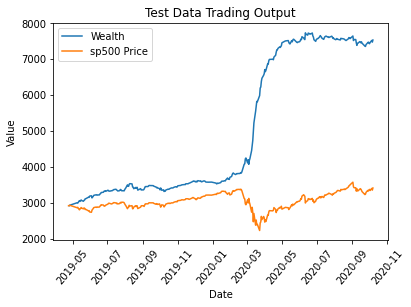

In [ ]:
Trade_Test['Order']=[1 if sig>0 else -1 for sig in Trade_Test['Signal']  ]
Trade_Test['Price_change']=Trade_Test['Price']-Trade_Test['Price'].shift(1)
Trade_Test['Profit']=Trade_Test['Price_change']*Trade_Test['Order']
print('Total profit is: $' + str(Trade_Test['Profit'].sum()))
Trade_Test['Wealth']=np.cumsum(Trade_Test['Profit'])+Trade_Test['Price'][0]
plt.plot(Trade_Test['Wealth'],label='Wealth')
plt.plot(Trade_Test['Price'],label='sp500 Price')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Test Data Trading Output')
plt.legend(loc="upper left")
degrees = 50
plt.xticks(rotation=degrees)

Total profit is: $7428.727606000006


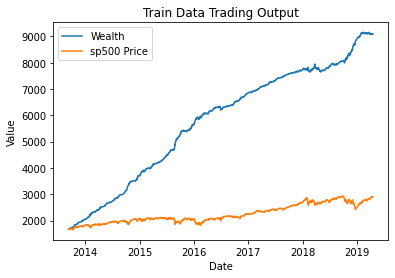

In [ ]:
Trade_Train['Order']=[1 if sig>0 else -1 for sig in Trade_Train['Signal']  ] # 1: buy, -1: short sell
Trade_Train['Price_change']=Trade_Train['Price']-Trade_Train['Price'].shift(1) # today's price - yesterday's price
Trade_Train['Profit']=Trade_Train['Price_change']*Trade_Train['Order']
print("Total profit is: $" + str(Trade_Train['Profit'].sum()))
Trade_Train['Wealth']=np.cumsum(Trade_Train['Profit'])+Trade_Train['Price'][0]
plt.plot(Trade_Train['Wealth'],label='Wealth')
plt.plot(Trade_Train['Price'],label='sp500 Price') # performance if you hold
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Train Data Trading Output')
plt.legend(loc="upper left")